In [1]:
"""
Author 1: Sai Mahesh
Roll No: CS18BTECH11001

Author 2: Vamshi Krishna Reddy
Roll No: CS18BTECH11024

Author 3: Sai Varshittha
Roll No: CS18BTECH11035
"""

'\nAuthor 1: Sai Mahesh\nRoll No: CS18BTECH11001\n\nAuthor 2: Vamshi Krishna Reddy\nRoll No: CS18BTECH11024\n\nAuthor 3: Sai Varshittha\nRoll No: CS18BTECH11035\n'

In [2]:
# Modules to be used
import torch
import torch.utils.data as dset
import matplotlib.pyplot as plt 
import numpy as np 
import copy
import torch.nn as nn
import pandas as pd 
import torch.optim as optim
import time
import datetime
import random

np.random.seed(0)
torch.random.manual_seed(0) 

In [3]:
# plot train vs Val accuracy/loss graphs
def plotGraph(epochs,str,train,val):
    plt.figure()
    plt.title('Train vs Val ' + str)
    plt.xlabel('Epochs')
    plt.ylabel(str)
    plt.plot(range(epochs), train, color='green', label = 'Train', marker='o', markersize=5)
    plt.plot(range(epochs), val, label = 'Val', marker='x', markersize=5)
    plt.savefig('./' + str + '_asg5.png')

In [4]:
def trainOrValidate(loader, isTrain):
	losses,correct,total = [], 0, 0
	for i, (x, y, cfn ) in enumerate(loader):
		if isTrain:
			optimizer.zero_grad()
		hx = net(x).squeeze(1) # calculate current model prediction
		pred = (hx-0.5>0).long()
		correct = correct + (pred==y).sum().item()
		lossVec = y*(hx*tpc + (1-hx)*cfn)
		lossVec += (1-y)*(hx*fpc + (1-hx)*tnc)
		loss = lossVec.mean() # calculate cost sensitive Loss
		total = total + hx.size(0)
		losses.append(loss.data.item())
		if isTrain:
			loss.backward() # calculate gradients
			optimizer.step()
	return correct, total, losses

In [5]:
# Training, validating and fitting model
def fitModel(train_loader, val_loader):
	global net, epochs, best_acc
	for epoch in range(0,epochs):
		# training
		net.train()
		correct,total,losses = trainOrValidate(train_loader,1)
		acc, meanLosses = 100*correct/total, np.mean(losses)
		train_acc.append(acc), train_loss.append(meanLosses)

		# validation
		net.eval()
		correct,total,losses = trainOrValidate(val_loader,0)
		acc, meanLosses = 100*correct/total, np.mean(losses)
		val_acc.append(acc), val_loss.append(meanLosses)

		if best_acc - val_acc[-1] < 0: # if val acc is better, save checkpoint
			best_acc = val_acc[-1]
			torch.save(net.state_dict(), './best.pth')
		print('(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : ({}, {:3f}, {:3f}, {:.3f}, {:.3f})'.format(epoch, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]))

In [6]:
# Load data
df = pd.read_csv('./costsensitivedata.csv')

# defining all Costs
tpc,tnc,fpc,fnc = 150.0,0,150.0,df.iloc[:,-1]

In [7]:
# converting data to Pytorch Tensors
df=df.drop(["FNC"], axis = 1)
fnc = torch.FloatTensor(fnc.to_numpy())

data = df.iloc[:,1:]
data = torch.FloatTensor(data.to_numpy())

targets  = df.iloc[:,0]
tempy = targets.to_numpy()
targets = torch.LongTensor(tempy)

In [8]:
# Split into train, validation and test data
dataset = dset.TensorDataset(data, targets, fnc)
tempy = [100000, 15000, 32636]
(train_set, validation_set, test_set) = dset.random_split(dataset, tempy)
train_loader = dset.DataLoader(train_set, batch_size=1024, shuffle=True, sampler=None)
val_loader = dset.DataLoader(validation_set, batch_size=1024, shuffle=False, sampler=None)
test_loader = dset.DataLoader(test_set, batch_size=1024, shuffle=False, sampler=None)

In [9]:
# Define Logistic Regressor
net = nn.Sequential( nn.Linear(df.columns.shape[0]-1,1),
					 nn.Sigmoid())
# optimizer to optimize weights
optimizer = optim.Adam(net.parameters())

In [10]:
# Training and validating using the data
epochs, best_acc, val_loss, train_loss, train_acc, val_acc = 20, 0, [], [], [], []
fitModel(train_loader,val_loader)

(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (0, 143.742143, 131.527442, 30.141, 30.027)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (1, 106.689487, 80.842398, 64.459, 84.733)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (2, 79.632237, 69.545502, 85.401, 86.153)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (3, 73.646359, 65.896644, 86.174, 86.347)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (4, 71.031963, 63.952661, 86.284, 86.287)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (5, 69.436363, 62.689408, 86.305, 86.273)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (6, 68.358450, 61.823607, 86.291, 86.293)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (7, 67.395331, 61.089448, 86.335, 86.340)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) : (8, 66.692558, 60.465270, 86.332, 86.327)
(Epoch, Train Loss, Val Loss, Train accuracy, Val accuracy) :

In [11]:
# Testing using the given data
total, true_pos, false_pos, false_neg , correct = 0, 0, 0, 0, 0
net.eval()
net.load_state_dict(torch.load('./best.pth'))
for i, (x, y, cfn ) in enumerate(test_loader): # evaluate on test data
	hx = net(x).squeeze(1)

	# for accuracy, find correct predictions
	pred = (hx-0.5>0).long()

	# find true positives, false positives, false negatives
	true_pos  = true_pos   + ((pred == 1)*(y==1)).sum().item() 
	false_pos = false_pos + ((pred == 1)*(y==0)).sum().item()
	false_neg = false_neg + ((pred == 0)*(y==1)).sum().item()

	correct += (pred - y == 0).sum().item()
	total = total + hx.size(0)

# Find accuracy, precision, recall, F1 Score
recall, precision =  true_pos, true_pos
recall /= (true_pos+false_neg)
precision /= (true_pos+false_pos)
f1 = 2/((1/precision) + (1/recall))

print('Test accuracy {:.3f}, Precision {:.3f}, Recall {:.3f}, F1 {:.3f}'.format(100.*correct/total, precision, recall, f1))

Test accuracy 86.530, Precision 0.782, Recall 0.754, F1 0.768


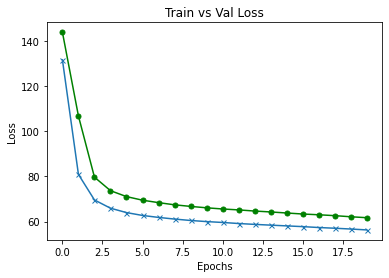

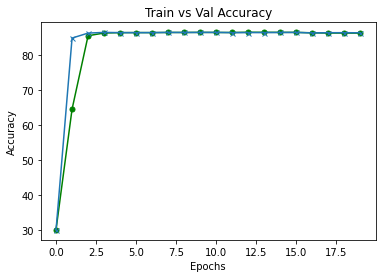

In [12]:
# plot graphs for train vs loss and accuracy
plotGraph(epochs,'Loss',train_loss,val_loss)
plotGraph(epochs,'Accuracy',train_acc,val_acc)